In [62]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
%matplotlib inline

In [16]:
train = pd.read_csv("mnist_train.csv")

In [17]:
targets_numpy = train.label.values

In [18]:
features_numpy = train.loc[:,train.columns != "label"].values/255


In [19]:
targets_numpy = targets_numpy.reshape(-1, 1)

In [116]:
# Make Data Loader

class MNISTDataset(Dataset):
    
    def __init__(self, csv_file, is_train=True):
        
        # Data Loading
        xy = pd.read_csv(csv_file)
        
        self.train_df = is_train
        
        if is_train:
            self.x = torch.from_numpy(xy.loc[:,train.columns != "label"].values/255) # Dont want first column
            self.y = torch.from_numpy(train.label.values)
        
        else:
            self.x = torch.from_numpy(xy.values/255)
            
        self.n_samples = xy.shape[0]
        
    def __getitem__(self, index):
         
            if self.train_df:
                return self.x[index], self.y[index]
            
            else:
                return self.x[index]
        # dataset[0]
        
    def __len__(self):
        return self.n_samples

In [21]:
dataset = MNISTDataset("mnist_train.csv")

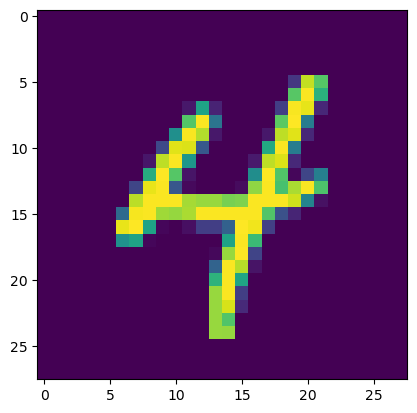

In [53]:
plt.imshow(dataset[39][0].reshape(28,28,1))

In [54]:
dataloader = DataLoader(dataset, batch_size=100, shuffle=True)

In [86]:
for ii in dataloader:
    print(ii[0].reshape(100, 1, 28,28).shape)
    break

torch.Size([100, 1, 28, 28])


In [87]:
class FCNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(FCNN, self).__init__()
        
        self.l1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.l2 = nn.Linear(hidden_size, num_classes)
        
    def forward(self, x):
        out = self.l1(x)
        out = self.relu(out)
        out = self.l2(out)
        
        return out

In [96]:
epochs = 10

input_size = 784
hidden_size = 100
num_classes = 10
learning_rate = 0.001

model = FCNN(input_size, hidden_size, num_classes)

In [97]:
criterion = nn.CrossEntropyLoss() # Loss fuction will apply softmax
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [98]:
n_total_steps = len(dataloader)

for epoch in range(epochs):
    for ii, (images, labels) in enumerate(dataloader):
        
        #Reshape images
        images = images.reshape(100, 784)
        images = images.to(torch.float32)
        #print(images.shape)
        
        #forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # backward
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (ii+1)%100 == 0:
            print(f"Epoch {epoch+1}/ {epochs}, step {ii+1}/{n_total_steps}, loss = {loss.item():.5f}")

Epoch 1/ 10, step 100/420, loss = 0.42834
Epoch 1/ 10, step 200/420, loss = 0.22059
Epoch 1/ 10, step 300/420, loss = 0.27143
Epoch 1/ 10, step 400/420, loss = 0.27494
Epoch 2/ 10, step 100/420, loss = 0.15224
Epoch 2/ 10, step 200/420, loss = 0.18330
Epoch 2/ 10, step 300/420, loss = 0.24635
Epoch 2/ 10, step 400/420, loss = 0.45008
Epoch 3/ 10, step 100/420, loss = 0.08397
Epoch 3/ 10, step 200/420, loss = 0.18618
Epoch 3/ 10, step 300/420, loss = 0.24262
Epoch 3/ 10, step 400/420, loss = 0.22178
Epoch 4/ 10, step 100/420, loss = 0.10553
Epoch 4/ 10, step 200/420, loss = 0.24695
Epoch 4/ 10, step 300/420, loss = 0.10666
Epoch 4/ 10, step 400/420, loss = 0.09186
Epoch 5/ 10, step 100/420, loss = 0.11415
Epoch 5/ 10, step 200/420, loss = 0.02743
Epoch 5/ 10, step 300/420, loss = 0.09448
Epoch 5/ 10, step 400/420, loss = 0.07720
Epoch 6/ 10, step 100/420, loss = 0.09324
Epoch 6/ 10, step 200/420, loss = 0.11271
Epoch 6/ 10, step 300/420, loss = 0.06239
Epoch 6/ 10, step 400/420, loss = 

In [120]:
test_dataset = MNISTDataset(csv_file="mnist_test.csv", is_train=False)
test_loader = DataLoader(test_dataset, batch_size=100, shuffle=False)

In [127]:
test_df = pd.read_csv("mnist_test.csv")

In [128]:
test_df.head()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [130]:
out_list = []

with torch.no_grad():

    for images in test_loader:
        images = images.reshape(100, 784)
        images = images.to(torch.float32)
        
        
        outputs = model(images)
        
        
        #value, index
        _, predictions = torch.max(outputs, 1)
        
        out_list.extend(predictions.tolist())
        

In [143]:
out_dict = {"Labels":out_list, "ImageId": [i for i in range(1,28001)]}

In [144]:
final_df = pd.DataFrame.from_dict(out_dict)

In [145]:
final_df.to_csv('mnist_output.csv', index=False)